# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import collections
import cv2
import fnmatch
import time
import os
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


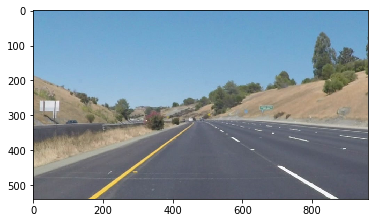

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# Used to average between frames
lines_buffer = collections.deque([], 6)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [14]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    # Create drawing surface for drawing the lines
    line_img = np.zeros(img.shape, dtype=np.uint8)
    
    for x1,y1,x2,y2 in lines:
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    # Blend the original image with the line image
    return weighted_img(line_img, img)

def clear_buffer():
    # We need to clear the line buffer between 
    # the processing of different images/videos
    lines_buffer.clear() 

def get_height_width(image):
    return image.shape[1], image.shape[0]


def get_masked_image(image):
    # HSV image
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # gray-scale image
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # get region of image within yellow range
    mask_yellow = cv2.inRange(image_hsv,
                              np.array([20, 100, 100]),  # yellow lower
                              np.array([100, 255, 255]))  # yellow upper

    # get region of image within white range
    mask_white = cv2.inRange(image_hsv,
                             np.array([0, 0, 240]),  # white lower
                             np.array([255, 255, 255]))  # white lower

    # merge results of yellow and white 
    mask_hsv = cv2.bitwise_or(mask_yellow, mask_white)
    
    # only retain the information of the lanes in the image
    masked_image = cv2.bitwise_and(image_gray, mask_hsv)
    return masked_image

def remove_image_noise(image, kernel=(3, 3)):
    filtered_image = cv2.GaussianBlur(image,  # source
                                      kernel,  # kernel size
                                      0)  # border type
    return filtered_image


def find_edges(image, low, high):
    edges = cv2.Canny(image,
                      low,  # low threshold
                      high)  # high threshold
    return edges


def get_masked_edges(width, height_bottom, height_top, edges, ignore_mask_color=255):
    mask = np.zeros_like(edges)
    
    # ROI vertices
    vertices = np.array([[(width * 0.05, height_bottom),  # left bottom
                          (width / 3, height_top),       # left top
                          (2 * width / 3, height_top),   # right top
                          (width * 0.95, height_bottom)]],# right bottom
                          dtype=np.int32)
    # create ROI
    cv2.fillPoly(mask,      # image
                 vertices,  # coordinates
                 ignore_mask_color)
    
    masked_edges = cv2.bitwise_and(edges, mask)
    return masked_edges


def get_hough_lines(image, rho=2, theta=1, voting=25,
                    min_line_length=20, max_line_gap=1):
    return cv2.HoughLinesP(image,  # source
                           rho,
                           theta * np.pi / 180,  # degree to radian
                           voting,  # minimum voting in hough accumulator
                           min_line_length,  # min line length in pixels
                           max_line_gap  # gap b/w lines in pixels
                           )

def get_lane_lines(input_lines, bottom_y, min_length=4):   
    slope_tolerance=.15  # Used to filter outliers
    top_y = int(bottom_y / 1.55) # defines how far in front of the car we display the lane lines.
                                 # As we are drawing lines not curves longer lines make only sense
                                 # if the street is streight or of the curve radius is large enough
    left_slope_avg=0
    right_slope_avg=0
    left_lines = []
    right_lines = [] 
    
    for line in input_lines:
        # get start and end coordinates of each line
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = float(y2 - y1) / float(x2 - x1) 
            length = math.sqrt(float(x2 - x1)**2 + float(y2 - y1)**2)
            
            # filter out small lines
            if length < min_length:
                continue
            if slope < 0.0:
                #lane left border line
                left_slope_avg = left_slope_avg + (slope - left_slope_avg) / (len(left_lines)+1)
                # Filter outliers
                if np.absolute(left_slope_avg - slope) < slope_tolerance:
                    left_lines.append((x1,y1))
                    left_lines.append((x2,y2))
            else:
                #lane right border line
                right_slope_avg = right_slope_avg + (slope - right_slope_avg) / (len(right_lines)+1)
                # Filter outliers
                if np.absolute(right_slope_avg - slope) < slope_tolerance:
                    right_lines.append((x1,y1))
                    right_lines.append((x2,y2))  
                    
    # Now we have sorted the individual line segments into those belonging to
    # the left and right lane border line. We will use the openCV function fitline()
    # to calculate a  mean line function for the given line segments
    if len(left_lines) > 0 and len(right_lines) > 0:
        [left_vx, left_vy, left_x, left_y] = cv2.fitLine(np.array(left_lines, dtype=np.int32),
                                                      cv2.DIST_L2,0,0.01,0.01) 
        
        # standard equation for a line is y = m * x + b
        # m = vy / vx (slope)
        
        left_m = left_vy / left_vx
        left_b = left_y - (left_m * left_x)

        [right_vx, right_vy, right_x, right_y] = cv2.fitLine(np.array(right_lines, dtype=np.int32), 
                                                          cv2.DIST_L2,0,0.01,0.01)    
        right_m= right_vy / right_vx
        right_b = right_y - (right_m * right_x)

        # store to average this line with previous frames       
        lines_buffer.append((left_b, left_m, right_b, right_m))
    
    # If used on video, we maintain a history of lines calculated for previous frames
    # and use them to average out the change per frame reduce jitter
    if len(lines_buffer) > 0: 
        [left_b, left_m, right_b, right_m] = np.sum(lines_buffer, -3) / len(lines_buffer)

        # Having the slope and intercept enables us to calculate the x coordinates of our desired
        # start and end points at the top and the bottom of the road.
        
        # Left line
        left_top_x = (top_y - left_b) / left_m
        left_bottom_x = (bottom_y - left_b) / left_m

        # Right line
        right_top_x = (top_y - right_b) / right_m
        right_bottom_x = (bottom_y - right_b) / right_m

        return [[int(left_bottom_x[0]), bottom_y, int(left_top_x[0]), top_y],
                [int(right_bottom_x[0]), bottom_y, int(right_top_x[0]), top_y]]
   
   
                

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [15]:
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [16]:
def process_image(image):
    width, height = get_height_width(image) 

    # Step 1 (color mask)
    masked_image = get_masked_image(image)

    #plt.imshow(masked_image) 

    # Step 2 (remove noise - apply gaussian blur filter)
    denoise = remove_image_noise(masked_image, kernel=(9, 9))

    #plt.imshow(masked_image) 

    # Step 3 Find edges using canny edge algorithm
    edges = find_edges(denoise, 50, 150) # 50 150

    #plt.imshow(edges) 

    # Step 4 Remove all edges outside of ROI
    masked_edges = get_masked_edges(width, height, height*0.55, edges)

    #plt.imshow(masked_edges) 


    # Step 5: find lines using hough
    hough_lines = get_hough_lines(masked_edges)
    lines = get_lane_lines(hough_lines, height)

    # Step 6: draw detected left and right lines
    return draw_lines(image, lines)


## Test on Images
Read all images contain in the test directory and apply the image processing pipeline


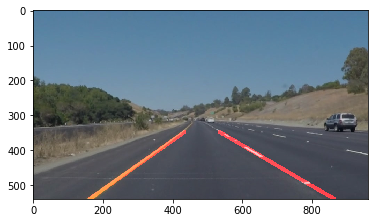

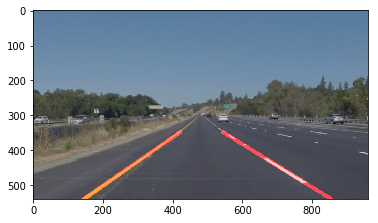

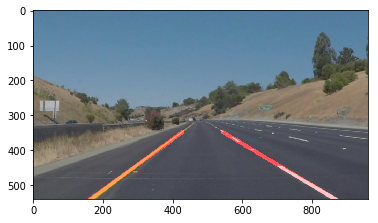

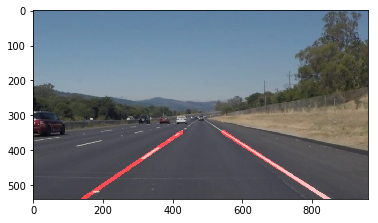

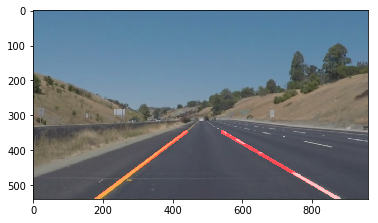

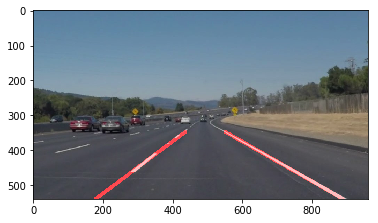

In [17]:
image_list = os.listdir("test_images/")

for image_file in image_list:
    clear_buffer()
    image = mpimg.imread('test_images/' + image_file)   
    image = process_image(image)
    mpimg.imsave('test_images_output/' + image_file, image)
    plt.figure()
    plt.imshow(image)  
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [18]:
def process_video(input_file, output_file):
    clear_buffer()
    input_clip = VideoFileClip(input_file)

    output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
    output_clip.write_videofile(output_file, audio=False)


Let's try the one with the solid white lane on the right first ...

In [19]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
process_video('test_videos/solidWhiteRight.mp4', white_output )

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 83.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [21]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

process_video('test_videos/solidWhiteRight.mp4', yellow_output )

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 221/222 [00:02<00:00, 83.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 



In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'

process_video('test_videos/challenge.mp4', challenge_output )

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:05<00:00, 47.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))